<a href="https://colab.research.google.com/github/aditeyabaral/haiku/blob/main/notebook/haiku_Sequence_Labelling_biLSTM_CRF_without_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
! pip install keras-self-attention
! pip install keras-crf

In [ ]:
import json
import numpy as np
import pandas as pd
import re
import string

import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
from keras_self_attention import SeqSelfAttention
from keras_crf import CRF
from keras.layers import Lambda
import tensorflow as tf
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/NLP/dataset.json") as d:
  dfd_json = json.load(d)

# Dataset Generation

In [ ]:
poems = list()
haikus = list()
indices = list()

MIN_THRESHOLD_HAIKU = 5
MAX_THRESHOLD_POEM = 120

for dataset in dfd_json:
  for poem in dataset:
    for grammar_index in poem:
      if grammar_index == "poem":
        continue
      else:
        haiku_data = poem[grammar_index]
        for haiku, index in list(haiku_data.items()):
          if len(index) >= MIN_THRESHOLD_HAIKU and len(poem["poem"].split()) <= MAX_THRESHOLD_POEM:
            poems.append(poem["poem"])
            haikus.append(haiku)
            indices.append(index)



df = pd.DataFrame()
df["poem"] = poems
df["haiku"] = haikus
df["indices"] = indices
df = df.drop_duplicates(subset=["poem"])
df = df.reset_index(drop=True)

In [ ]:
df.shape

(16903, 3)

In [ ]:
df = df.sample(1000)
df.head()

,poem,haiku,indices
11404,I was conceived in the cruelest monthin whatev...,california mustera some more buckeyes on the s...,"[9, 11, 14, 15, 18, 22, 23, 28]"
5458,WHEN the flaming lute-thronged angelic door is...,door hearts the bitter faces in the sponge,"[5, 17, 19, 28, 29, 32, 36, 38]"
1992,"Inspiration: ''The Black Cat'' / August,1843\n...",thirtyfour hideous fades by the eye,"[7, 18, 20, 22, 29, 34]"
16167,On a parking lot staircase\nI met two fine-loo...,parking slacks the other years on a son,"[2, 13, 22, 28, 32, 35, 39, 40]"
5699,Racism\nEats you up inside.\nPlays upon\nyou'r...,racism perceptions that dark skin,"[0, 10, 13, 20, 21]"


In [ ]:
def clean(s):
    s = s.translate(str.maketrans('', '', string.punctuation)).strip().lower()
    return s

In [ ]:
poems = list(df["poem"])
tags = list(df["indices"])
poem_no = []
word = []
tag = []

for i in range(len(poems)):
    poem = poems[i].split()

    count_poem = [i+1] * len(poem)
    poem_no.extend(count_poem)

    word.extend(poem)

    count_tag = [0] * len(poem)
    for j in tags[i]:
        count_tag[j] = 1
    tag.extend(count_tag)

word = list(map(clean, word))

In [ ]:
dataset = {"poem_no" : poem_no, "word" : word, "tag" : tag}
df = pd.DataFrame(dataset)
df = df[df["word"] != ""]

In [ ]:
df.head()

,poem_no,word,tag
0,1,i,0
1,1,was,0
2,1,conceived,0
3,1,in,0
4,1,the,0


In [ ]:
df.shape

(80271, 3)

# Model Building

In [ ]:
words = list(set(df["word"].values))
words.append("ENDPAD")

In [ ]:
n_words = len(words); n_words

13311

In [ ]:
tags = list(set(df["tag"].values))

In [ ]:
n_tags = len(tags); n_tags

2

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("poem_no").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        # try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        # except:
        #     return None

In [ ]:
getter = SentenceGetter(df)
sent = getter.get_next()

In [ ]:
print(sent)

[('i', 0), ('was', 0), ('conceived', 0), ('in', 0), ('the', 0), ('cruelest', 0), ('monthin', 0), ('whatever', 0), ('spring', 0), ('california', 1), ('could', 0), ('mustera', 1), ('little', 0), ('rain—with', 0), ('some', 1), ('more', 1), ('likelyand', 0), ('the', 0), ('buckeyes', 1), ('were', 0), ('they', 0), ('yet', 0), ('on', 1), ('the', 1), ('grounddamn', 0), ('my', 0), ('father’s', 0), ('smooth', 0), ('stone', 1), ('eyesother', 0), ('prevailing', 0), ('enticements', 0), ('and', 0), ('what', 0), ('eliot', 0), ('calledthe', 0)]


In [ ]:
sentences = getter.sentences # list(list(("word", tag)))

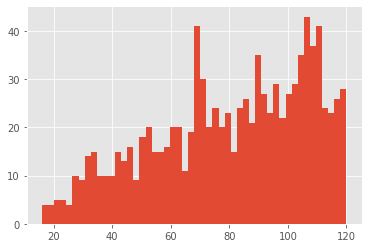

In [ ]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
max_len = 120
word2idx = {w: i for i, w in enumerate(words)}  # {word:enum}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X[1]

array([ 6366,  5720,  3323,   754,  6063,  6369,  8522,  9504,  6366,
        8118,  5194,  6436, 12503,  9389, 11461, 12498,  2622,  2645,
       10631,  5720,   261,  5720, 10569,  2967,  5720, 10535,  2195,
         427,  4088,  3925,  5720,  6159,  9389, 11174,  1652,   691,
        5720,  3503,  1909,  5720,  9312,  3273,  8573,  8870,  5626,
        7562, 11561,  2853,  1652,  2725,  2622,  4960,  3341,  8926,
       12339,  1223,  2196, 13111,  8648,  7463,  1652,  1921,  2043,
         427,  6147,  9735, 12670, 11591,  3241, 11256, 12670, 11510,
        3497, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310,
       13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310,
       13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310,
       13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310,
       13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310, 13310,
       13310, 13310, 13310], dtype=int32)

In [ ]:
X.shape

(1000, 120)

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx[0])
y[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
y = [to_categorical(i, num_classes=n_tags) for i in y]
y[1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=120, input_length=max_len)(input)  # 120-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
# model = SeqSelfAttention()(model)
model = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

crf_model = CRF(n_tags)  
out = crf_model(model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


In [ ]:
model = Model(input, out)

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
np.array(y_train).shape

(900, 120, 2)

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=48, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


17/17 [==============================] - 16s 613ms/step - loss: 15.3628 - accuracy: 0.0469 - val_loss: 8.1799 - val_accuracy: 0.4925
Epoch 2/5
17/17 [==============================] - 9s 556ms/step - loss: 15.3606 - accuracy: 0.0470 - val_loss: 8.1799 - val_accuracy: 0.4925
Epoch 3/5
17/17 [==============================] - 9s 555ms/step - loss: 15.3659 - accuracy: 0.0467 - val_loss: 8.1799 - val_accuracy: 0.4925
Epoch 4/5
17/17 [==============================] - 9s 554ms/step - loss: 15.3598 - accuracy: 0.0471 - val_loss: 8.1799 - val_accuracy: 0.4925
Epoch 5/5
17/17 [==============================] - 9s 554ms/step - loss: 15.3602 - accuracy: 0.0470 - val_loss: 8.1799 - val_accuracy: 0.4925


In [ ]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy,val_loss,val_accuracy
0,15.363628,0.046811,8.179934,0.4925
1,15.363628,0.046811,8.179934,0.4925
2,15.363628,0.046811,8.179934,0.4925
3,15.363628,0.046811,8.179934,0.4925
4,15.363627,0.046811,8.179934,0.4925


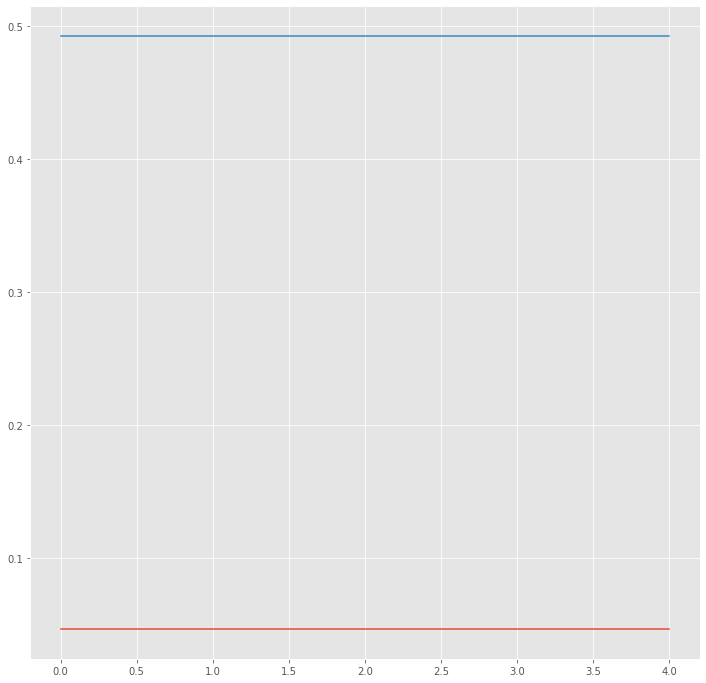

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

# Testing

In [ ]:
for i in range(20):

    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)

    sent = []
    true = []
    pred = []

    for w in X_test[i]:
        sent.append(words[w])



    true_label = []
    for j in range(len(y_test[i])):
        ind = y_test[i][j][-1]
        true_label.append(int(ind))

    for y in range(len(true_label)):
        if true_label[y] == 1:
            true.append(sent[y])



    pred_label = p[0]
    for k in range(len(pred_label)):
        if pred_label[k] == 1:
            pred.append(sent[k])

    sent = " ".join(sent)
    true = " ".join(true)
    pred = " ".join(pred)

    print("Sentence = ", sent)
    print()
    print("True = ", true)
    print()
    print("Predicted = ", pred)

    print("\n\n\n")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Sentence =  my reading is extremely deep and wide and as our modern education goes— unique i think and skilfully applied to art and industry and autres choses through many years of scholarly repose but there is one thing where i disappoint my numerous admirers and my foes painting on vellum is my weakest point ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD ENDPAD

True =  reading choses repose is on

Predicted =  my is deep wide as modern goes— i and applied art industry autres through years scholarly but is one where disappoint numerous and foes on is weakest ENDPAD ENDPAD ENDP

# References

1) https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/

2) https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/


# Save Model

In [ ]:
# model.save("seq-lab.h5")

# from google.colab import files
# files.download("seq-lab.h5")

# Load and Test the model

In [ ]:
# from random import randint
# from tensorflow import keras

In [ ]:
# model = keras.models.load_model('seq-lab.h5')

In [ ]:
 # # i = randint(1,len(X_te))

# for i in range(100):

#     p = model.predict(np.array([X_test[i]]))
#     p = np.argmax(p, axis=-1)

#     sent = []
#     true = []
#     pred = []

#     for w in X_test[i]:
#         sent.append(words[w])



#     true_label = []
#     for j in range(len(y_test[i])):
#         ind = y_test[i][j][-1]
#         true_label.append(int(ind))

#     for y in range(len(true_label)):
#         if true_label[y] == 1:
#             true.append(sent[y])



#     pred_label = p[0]
#     for k in range(len(pred_label)):
#         if pred_label[k] == 1:
#             pred.append(sent[k])



#     print("Sentence = ", sent)
#     print("True = ", true)
#     print("Predicted = ", pred)

#     print("\n\n\n")